In [1]:
import sys
import logging
import dbclients
import scgenome.utils

from scgenome.loaders.qc import load_cached_qc_data
from scgenome.db.qc import cache_qc_results
from scgenome.analyses.infer_clones import load_cell_cycle_data

LOGGING_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=LOGGING_FORMAT, stream=sys.stderr, level=logging.INFO)

tantalus_api = dbclients.tantalus.TantalusApi()

hmmcopy_tickets = [
    'SC-1935',
    'SC-1936',
    'SC-1937',
]

sample_ids = [
    'SA922',
    'SA921',
    'SA1090',
]

local_cache_directory = '/Users/mcphera1/Scratch/tantalus_data/'

cn_data = []
segs_data = []
metrics_data = []
align_metrics_data = []

for jira_ticket in hmmcopy_tickets:
#     cache_qc_results(jira_ticket, local_cache_directory)
    hmmcopy_data = load_cached_qc_data(jira_ticket, local_cache_directory, sample_ids=sample_ids)

    if 'is_s_phase' not in hmmcopy_data['hmmcopy_metrics']:
        cell_cycle_data = load_cell_cycle_data(
            tantalus_api,
            jira_ticket)
        cell_cycle_data['cell_id'] = cell_cycle_data['cell_id'].astype('category')

        scgenome.utils.union_categories([hmmcopy_data['hmmcopy_metrics'], cell_cycle_data])

        hmmcopy_data['hmmcopy_metrics'] = hmmcopy_data['hmmcopy_metrics'].merge(cell_cycle_data, how='left')
        assert 'cell_id_x' not in hmmcopy_data['hmmcopy_metrics']

    cn_data.append(hmmcopy_data['hmmcopy_reads'])
    segs_data.append(hmmcopy_data['hmmcopy_segs'])
    metrics_data.append(hmmcopy_data['hmmcopy_metrics'])
    align_metrics_data.append(hmmcopy_data['align_metrics'])

cn_data = scgenome.utils.concat_with_categories(cn_data)
segs_data = scgenome.utils.concat_with_categories(segs_data)
metrics_data = scgenome.utils.concat_with_categories(metrics_data)
align_metrics_data = scgenome.utils.concat_with_categories(align_metrics_data)


/Users/mcphera1/Projects/scgenome/scgenome/loaders/utils.py:44: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  manifest = yaml.load(open(manifest_filename))
/Users/mcphera1/Projects/scgenome/scgenome/loaders/align.py:90: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  manifest = yaml.load(open(manifest_filename))
/Users/mcphera1/Projects/scgenome/scgenome/loaders/hmmcopy.py:114: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  manifest = yaml.load(open(manifest_filename))
/Users/mcphera1/Projects/scgenome/scgenome/utils.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [2]:

metrics_data['is_s_phase_null'] = metrics_data['is_s_phase'].isnull()
metrics_data.groupby('library_id')['is_s_phase'].any()


library_id
A90554A    True
A90554B    True
A96213A    True
Name: is_s_phase, dtype: bool

(1966, 44)
(1040, 1)


/Users/mcphera1/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
2019-09-05 16:21:59,842 - INFO - matrix with size (11, 6206)
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:150: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


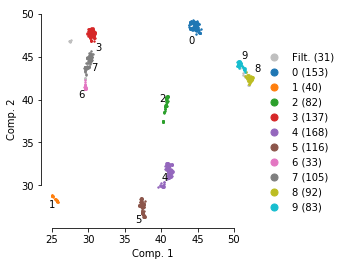

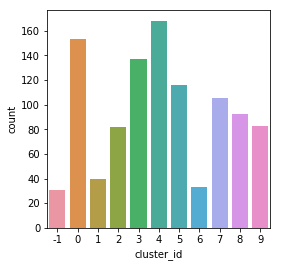

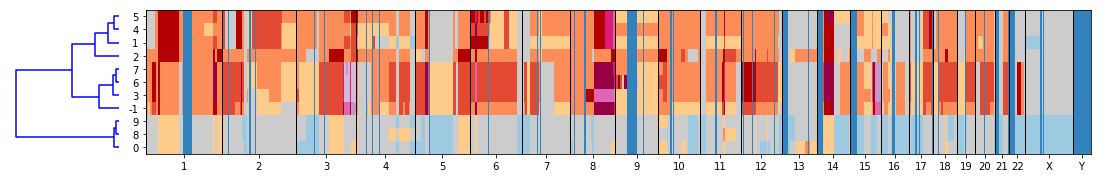

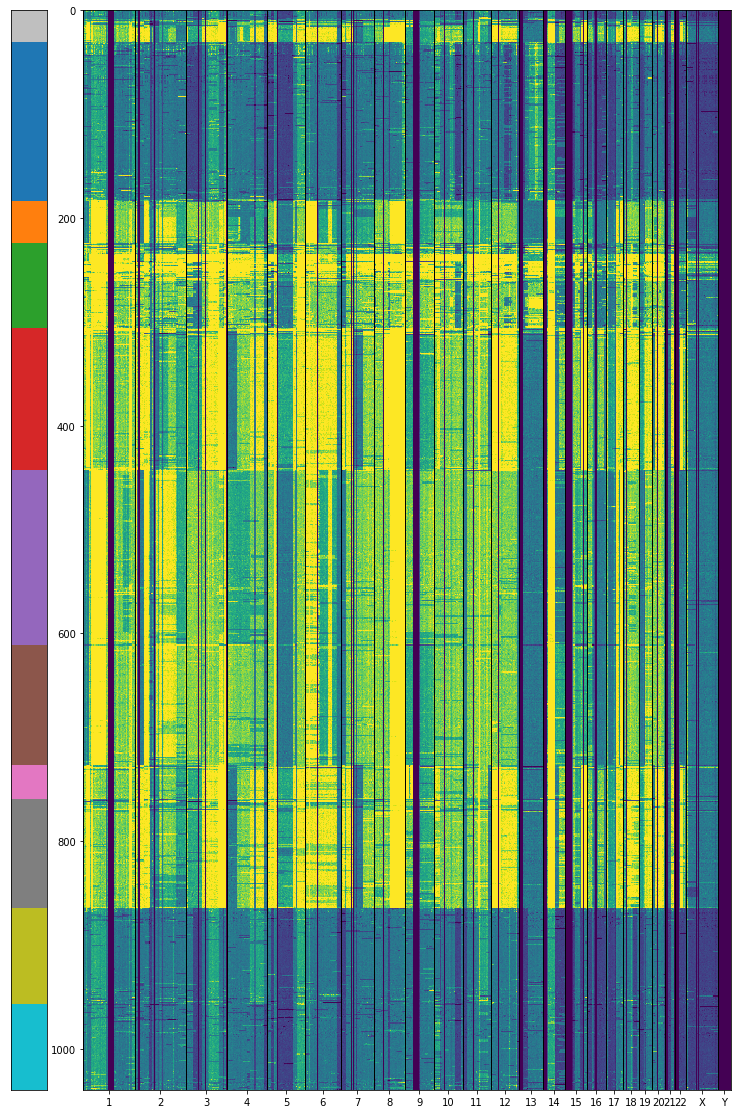

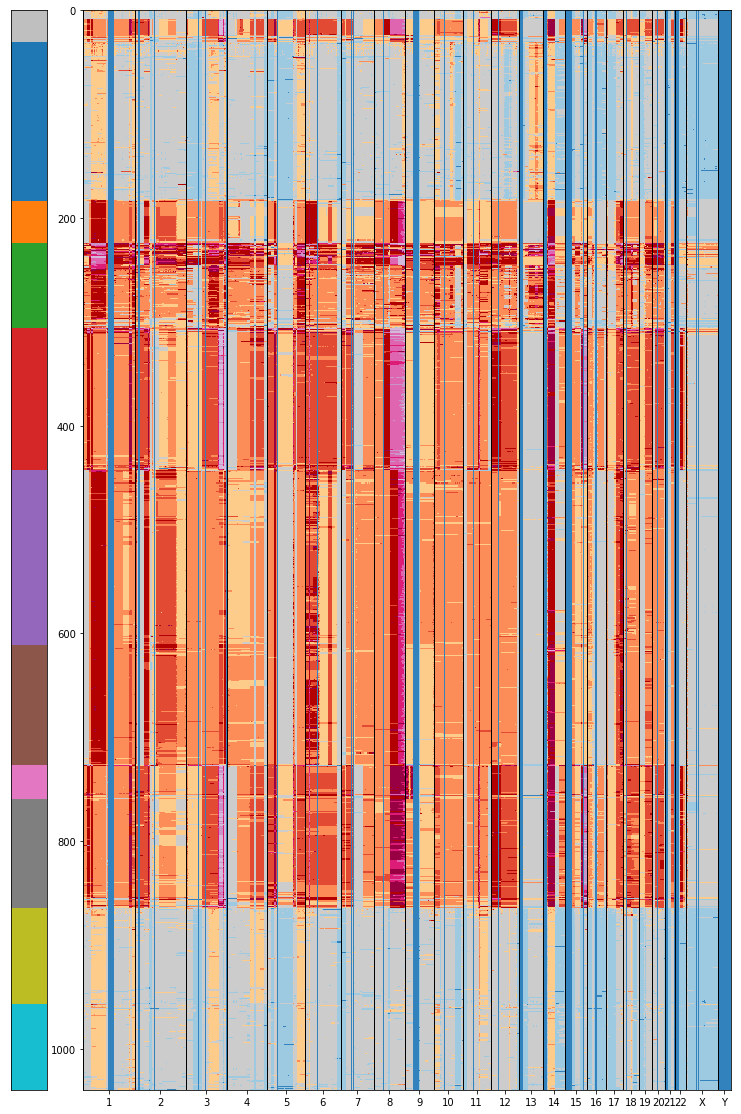

In [3]:

import scgenome.cncluster
import scgenome.cnplot
import matplotlib.pyplot as plt
import scipy.stats
import seaborn
import numpy as np
import pandas as pd


def calc_prop_hom_del(states):
    cndist = states.value_counts()
    cndist = cndist / cndist.sum()
    if 0 not in cndist:
        return 0
    return cndist[0]

metrics_data['filter_quality'] = (metrics_data['quality'] > 0.75)
metrics_data['filter_reads'] = (metrics_data['total_mapped_reads_hmmcopy'] > 500000)
print(metrics_data.shape)

# Calculate proportion homozygous deletion state
prop_hom_del = cn_data.groupby('cell_id')['state'].apply(calc_prop_hom_del).rename('prop_hom_del').reset_index()
metrics_data = metrics_data.merge(prop_hom_del, how='left')
metrics_data['prop_hom_del'] = metrics_data['prop_hom_del'].fillna(0)
metrics_data['zscore_prop_hom_del'] = scipy.stats.zscore(metrics_data['prop_hom_del'])
metrics_data['filter_prop_hom_del'] = (metrics_data['zscore_prop_hom_del'] < 3.)

# Calculate separation between predicted and normalized copy number
copy_state_diff = cn_data[['cell_id', 'copy', 'state']].copy()
copy_state_diff['copy_state_diff'] = np.absolute(copy_state_diff['copy'] - copy_state_diff['state'])
copy_state_diff = (copy_state_diff[['cell_id', 'copy_state_diff']]
    .dropna().groupby('cell_id')['copy_state_diff']
    .mean().reset_index().dropna())
metrics_data = metrics_data.merge(copy_state_diff)
metrics_data['filter_copy_state_diff'] = (metrics_data['copy_state_diff'] < 1.)

# Remove s phase cells
# Remove low quality cells
# Remove low coverage cells
# Remove cells with a large divergence between copy state and norm copy number
# Remove cells with outlier proportion of homozygous deletion
filtered_cells = metrics_data.loc[
    (~metrics_data['is_s_phase']) &
    metrics_data['filter_quality'] &
    metrics_data['filter_reads'] &
    metrics_data['filter_copy_state_diff'] &
    metrics_data['filter_prop_hom_del'],
    ['cell_id']]

print(filtered_cells.shape)

cn_data = cn_data.merge(filtered_cells[['cell_id']].drop_duplicates())
assert isinstance(cn_data['cell_id'].dtype, pd.api.types.CategoricalDtype)

cn = (
    cn_data
        .set_index(['chr', 'start', 'end', 'cell_id'])['copy']
        .unstack(level='cell_id').fillna(0)
)

clusters = scgenome.cncluster.umap_hdbscan_cluster(cn)

fig = plt.figure(figsize=(4, 4))
scgenome.cncluster.plot_umap_clusters(plt.gca(), clusters)

fig = plt.figure(figsize=(4, 4))
seaborn.barplot(x='cluster_id', y='count', data=clusters.groupby('cluster_id').size().rename('count').reset_index())

cn_data = cn_data.merge(clusters[['cell_id', 'cluster_id']].drop_duplicates())

plot_data = cn_data.copy()
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

cluster_col = 'cluster_id'

fig = plt.figure(figsize=(15, 2))
scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name=cluster_col)

fig = plt.figure(figsize=(10, 15))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', cluster_field_name=cluster_col, raw=True)

fig = plt.figure(figsize=(10, 15))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state', cluster_field_name=cluster_col)


In [13]:

from scgenome.jointcnmodels import calculate_ll_normal_simple
from remixt.bpmodel import max_product


import scipy.stats
import scipy
from remixt.bpmodel import sum_product


from scgenome.jointcnmodels import calculate_marginal_ll_simple
from scgenome.jointcnmodels import gibbs_sample_cluster_indices
from scgenome.jointcnmodels import calculate_ll_normal_simple



In [14]:

# subset cells
cell_ids = cn_data['cell_id'].unique()
np.random.shuffle(cell_ids)
cell_ids = cell_ids[:50]

matrix_data = (
    cn_data
    .merge(pd.DataFrame({'cell_id': cell_ids}))
    .set_index(['chr', 'start', 'cell_id'])
    [['reads', 'state', 'copy']]
    .unstack(level=2, fill_value=0.))


In [30]:


cn = matrix_data['state'].astype(int).values
reads = matrix_data['reads'].values
hmmcopy_cn = matrix_data['state'].values
copy = matrix_data['copy'].values

measurement = copy.T

n_segments = measurement.shape[1]
n_states = 8
n_cells = measurement.shape[0]

cell_state_var = cn_data[['cell_id', 'state', 'copy']].dropna().groupby(['cell_id', 'state'])['copy'].var().rename('copy_var').reset_index()
#cell_state_var = cell_state_var.merge(cn_data[['cell_id', 'measurement']].drop_duplicates())

variances = cell_state_var.set_index(['state', 'cell_id'])['copy_var'].unstack()
variances = variances.reindex(columns=matrix_data['reads'].columns, index=range(n_states)).fillna(0.05).T
variances = variances.values

variances[variances < 0.001] = 0.001

print(variances.shape)

tr_probs = np.zeros((n_segments, n_states, n_states))
tr_probs[:] += 1.
tr_probs[:, range(n_states), range(n_states)] += 100.
tr_probs /= tr_probs.sum(axis=2)[:, :, np.newaxis]
tr_mat = np.log(tr_probs)

e0 = 0.9
e1 = (1. - e0) / n_states
print(e1, e0)

transmodel = {'kind': 'twoparam', 'e0': e0, 'e1': e1}

print(calculate_marginal_ll_simple(measurement, variances, transmodel))

# variances = np.ones((n_cells, n_states)) * 0.25

assignments = np.zeros((n_cells,), dtype=int)

alpha = 0.001
max_clusters = 20


(50, 8)
0.012499999999999997 0.9
-2284023.4698788994


In [31]:

pair_log_marginals = np.zeros((n_cells, n_cells))

for i in range(n_cells):
    print(i)
    for j in range(n_cells):
        log_marginal_pair = calculate_marginal_ll_simple(
            measurement[[i,j], :],
            variances[[i,j], :],
            transmodel)
        pair_log_marginals[i, j] = log_marginal_pair


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


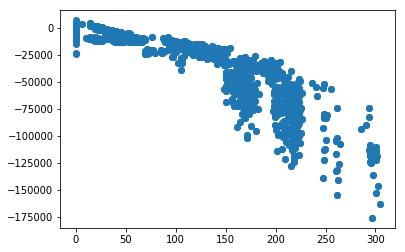

In [41]:

from scipy.spatial.distance import pdist, squareform
pw_euc = squareform(pdist(cn.T))

plt.scatter(pw_euc.flatten(), pair_log_marginals.flatten())


[-1  0  1  2]


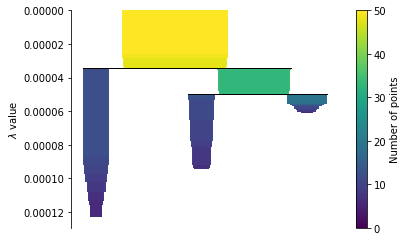

In [32]:

import hdbscan

clusterer = hdbscan.HDBSCAN(metric='precomputed')#, min_cluster_size=20, min_samples=60)
clusterer.fit(pair_log_marginals.max()-pair_log_marginals)
clusterer.condensed_tree_.plot()
print(np.unique(clusterer.labels_))


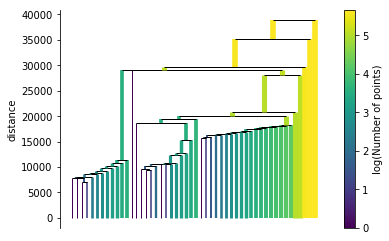

In [33]:

clusterer.single_linkage_tree_.plot()


/Users/mcphera1/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


,cell_id,cluster_id,umap1,umap2
0,SA1090-A96213A-R20-C32,0,50.801266,44.423439
1,SA1090-A96213A-R20-C40,1,40.828743,39.771786
2,SA1090-A96213A-R24-C44,0,45.030128,48.364784
3,SA1090-A96213A-R24-C56,-1,40.594242,39.248985
4,SA1090-A96213A-R24-C57,-1,40.478680,38.705727


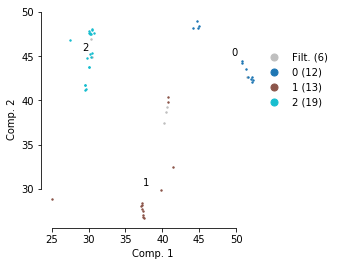

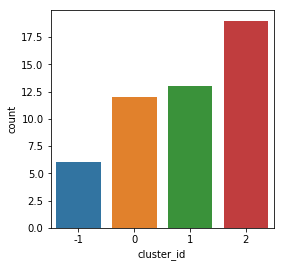

In [34]:


distmat_clusters = pd.DataFrame({'distmat_cluster_id': clusterer.labels_}, index=matrix_data['copy'].columns).reset_index()

distmat_clusters = distmat_clusters.merge(clusters).drop(['cluster_id'], axis=1).rename(columns={'distmat_cluster_id': 'cluster_id'})

fig = plt.figure(figsize=(4, 4))
scgenome.cncluster.plot_umap_clusters(plt.gca(), distmat_clusters)

fig = plt.figure(figsize=(4, 4))
seaborn.barplot(x='cluster_id', y='count', data=distmat_clusters.groupby('cluster_id').size().rename('count').reset_index())

distmat_clusters.head()



2019-09-06 15:12:46,698 - INFO - matrix with size (4, 6206)
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:150: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


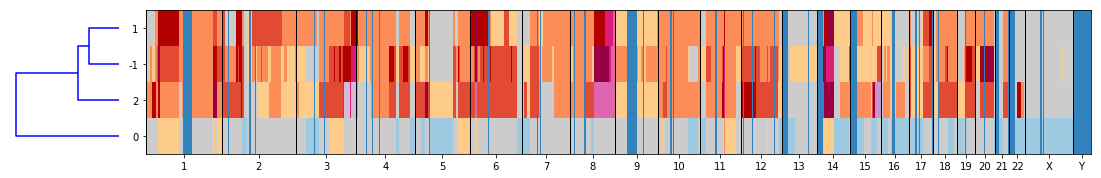

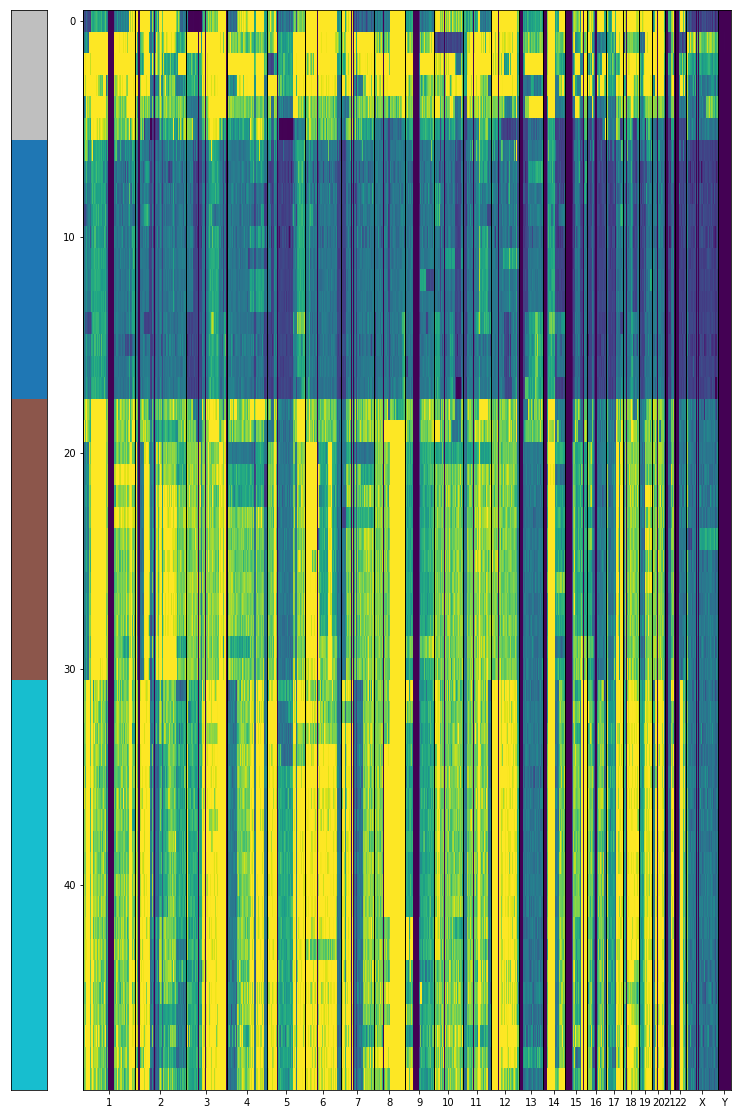

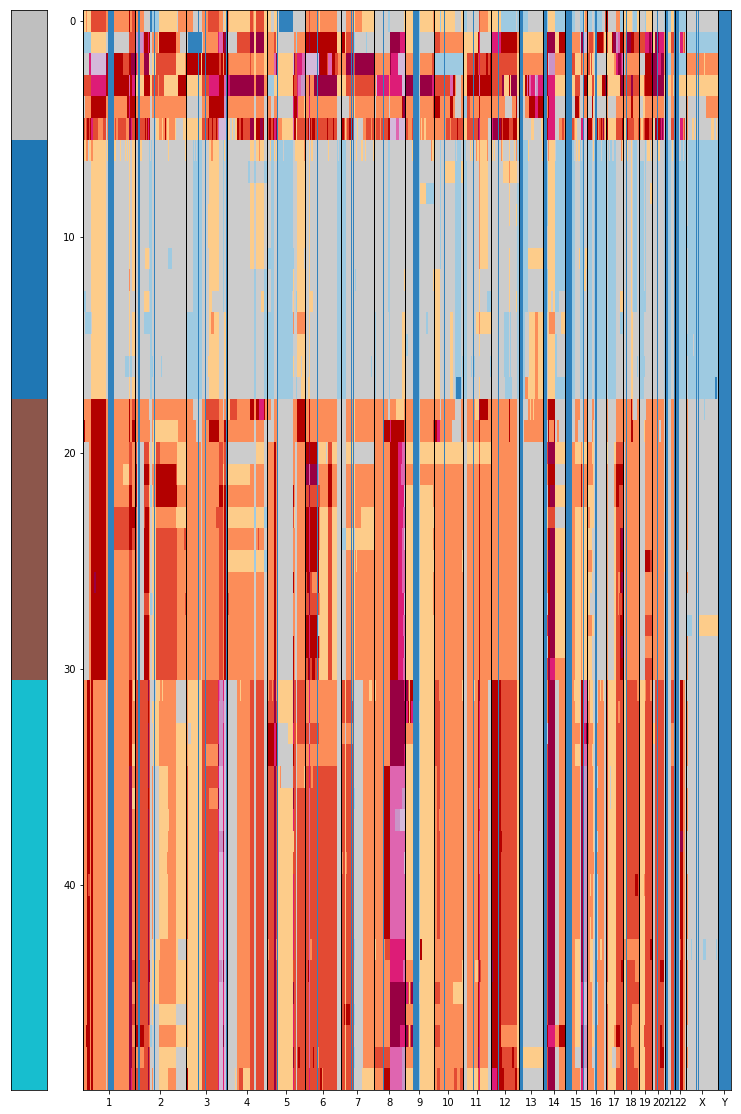

In [35]:


plot_data = cn_data.copy()
plot_data = plot_data.drop(['cluster_id'], axis=1).merge(distmat_clusters)
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

cluster_col = 'cluster_id'

fig = plt.figure(figsize=(15, 2))
scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name=cluster_col)

fig = plt.figure(figsize=(10, 15))
_ = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', cluster_field_name=cluster_col, raw=True)

fig = plt.figure(figsize=(10, 15))
_ = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state', cluster_field_name=cluster_col)


In [33]:


framelogprob = calculate_ll_normal_simple(measurement, variances).sum(axis=0)

alphas = np.zeros(framelogprob.shape)
betas = np.zeros(framelogprob.shape)

%timeit remixt.bpmodel.sum_product_2paramtrans(framelogprob, alphas, betas, e0, e1)


100 loops, best of 5: 5.05 ms per loop


In [23]:

%timeit -n 100 remixt.bpmodel.sum_product(framelogprob, tr_mat, alphas, betas)


100 loops, best of 5: 58.9 ms per loop


In [25]:

%prun gibbs_sample_cluster_indices(measurement, variances, assignments, max_clusters, alpha, e0, e1)


         254630 function calls in 43.529 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4000   26.882    0.007   26.882    0.007 {built-in method remixt.bpmodel.sum_product_2paramtrans}
     4000   12.035    0.003   13.976    0.003 jointcnmodels.py:6(calculate_ll_normal_simple)
     6826    1.849    0.000    1.849    0.000 {method 'repeat' of 'numpy.ndarray' objects}
    14200    0.907    0.000    0.907    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.693    0.693   43.529   43.529 jointcnmodels.py:53(gibbs_sample_cluster_indices)
     4000    0.631    0.000   42.797    0.011 jointcnmodels.py:38(calculate_marginal_ll_simple)
     4000    0.114    0.000    0.359    0.000 _logsumexp.py:9(logsumexp)
     8100    0.099    0.000    0.099    0.000 {built-in method numpy.zeros}
     4000    0.051    0.000    1.928    0.000 shape_base.py:1154(tile)
     4000    0.043    0.000    0.062    0.000 _util.py:192(_

In [34]:

for i in range(20):
    print(i)
    assignments = gibbs_sample_cluster_indices(measurement, variances, assignments, max_clusters, alpha, e0, e1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/mcphera1/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


,cell_id,cluster_id,umap1,umap2
0,SA1090-A96213A-R20-C18,7,42.249760,38.082951
1,SA1090-A96213A-R20-C22,11,41.065716,50.057613
2,SA1090-A96213A-R20-C31,19,41.201347,37.944199
3,SA1090-A96213A-R20-C32,17,45.160511,46.752960
4,SA1090-A96213A-R20-C33,6,39.972382,50.366615


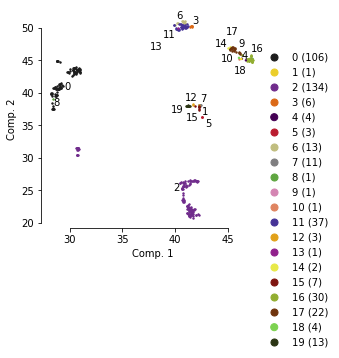

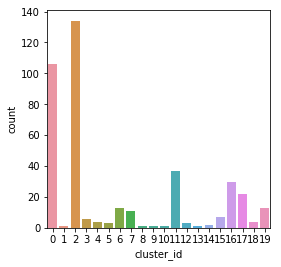

In [35]:

gibbs_clusters = pd.DataFrame({'gibbs_cluster_id': assignments}, index=matrix_data['copy'].columns).reset_index()

gibbs_clusters = gibbs_clusters.merge(clusters).drop(['cluster_id'], axis=1).rename(columns={'gibbs_cluster_id': 'cluster_id'})

fig = plt.figure(figsize=(4, 4))
scgenome.cncluster.plot_umap_clusters(plt.gca(), gibbs_clusters)

fig = plt.figure(figsize=(4, 4))
seaborn.barplot(x='cluster_id', y='count', data=gibbs_clusters.groupby('cluster_id').size().rename('count').reset_index())

gibbs_clusters.head()


2019-08-17 13:44:42,514 - INFO - matrix with size (20, 6206)
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:150: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


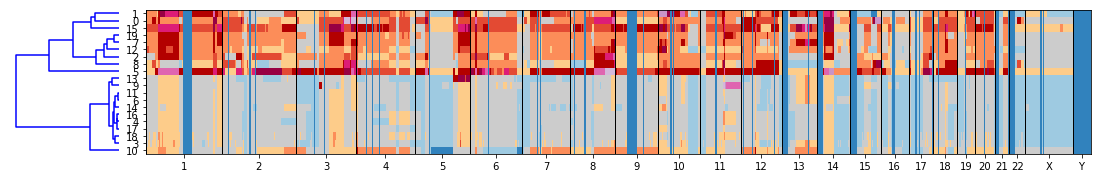

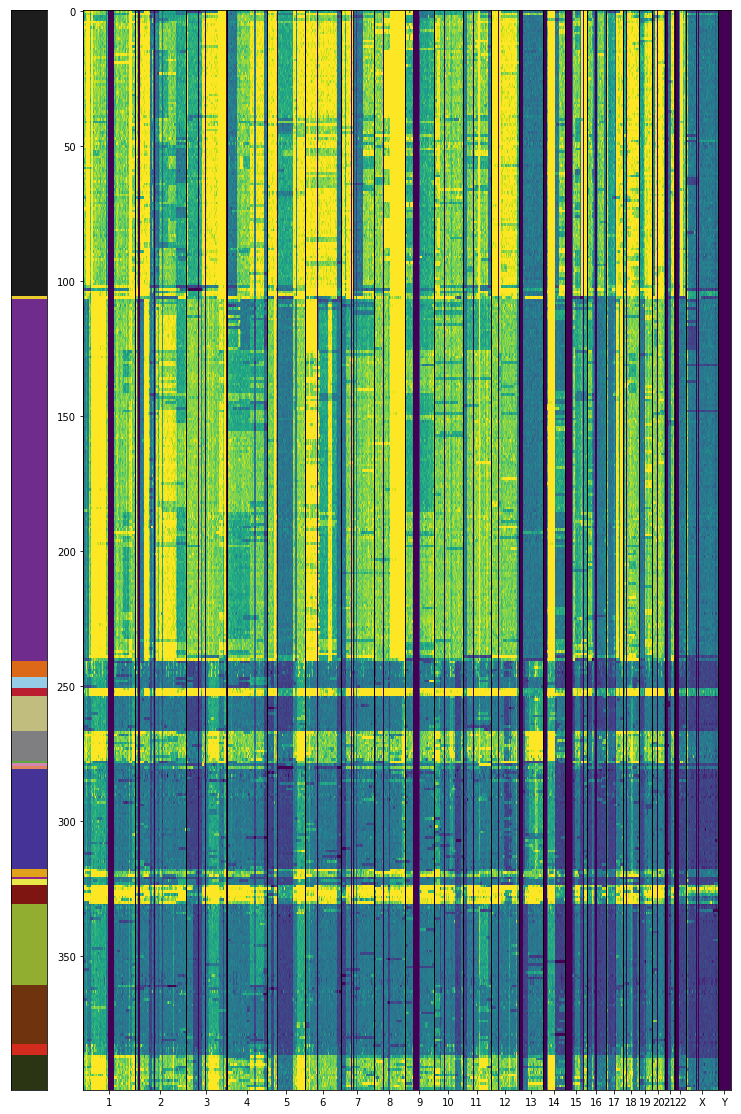

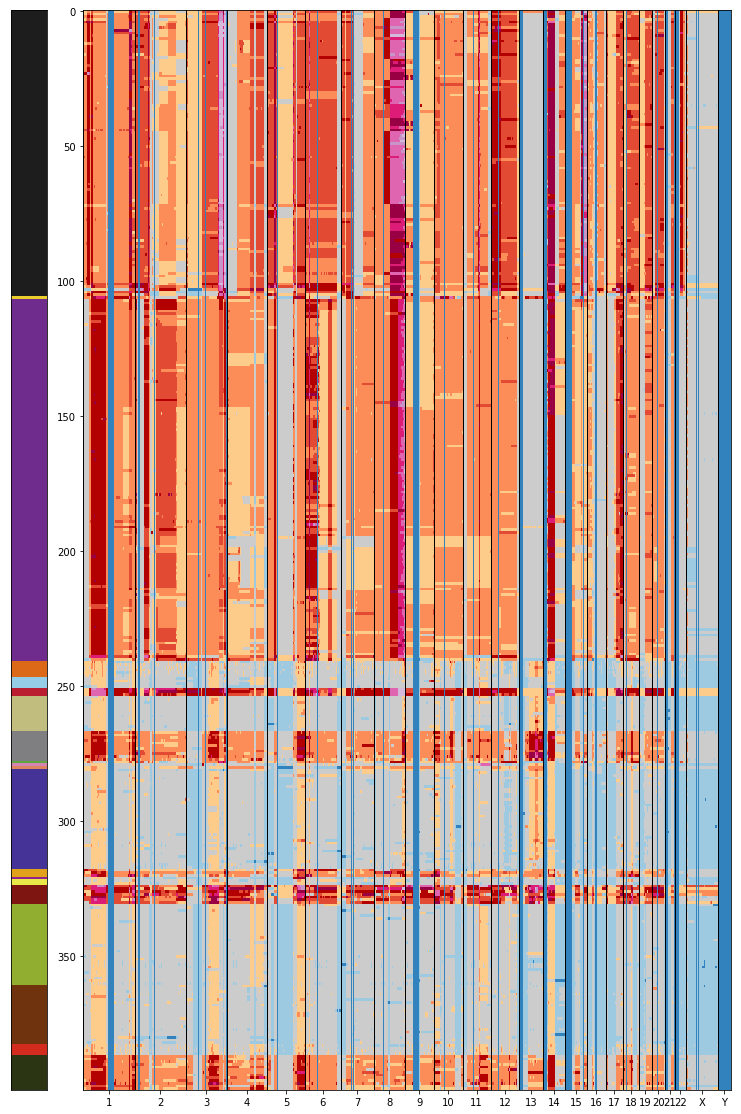

In [37]:

plot_data = cn_data.copy()
plot_data = plot_data.drop(['cluster_id'], axis=1).merge(gibbs_clusters)
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

cluster_col = 'cluster_id'

fig = plt.figure(figsize=(15, 2))
scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name=cluster_col)

fig = plt.figure(figsize=(10, 15))
_ = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', cluster_field_name=cluster_col, raw=True)

fig = plt.figure(figsize=(10, 15))
_ = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state', cluster_field_name=cluster_col)
